In [1]:
import pandas as pd
import networkx as nx
from node2vec import Node2Vec
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Load and process data
trades = pd.read_csv('Iron_dealers_data_short.csv') # Assuming 'trades.csv' contains the data
edges = trades[['Buyer ID', 'Seller ID']].values.tolist()
G = nx.DiGraph()
G.add_weighted_edges_from([(edge[0], edge[1], trades.loc[(trades['Buyer ID'] == edge[0]) & (trades['Seller ID'] == edge[1]), 'Value'].values[0]) for edge in edges])

# Step 2: Embed nodes using Node2Vec
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1)

# Step 3: Cluster nodes to identify sets of dealers doing circular trading
kmeans = KMeans(n_clusters=6, random_state=0)
node_embeddings = [model.wv.get_vector(str(node)) for node in G.nodes()]
clusters = kmeans.fit_predict(node_embeddings)

# Step 4: Print out identified clusters
for i in range(5):
    print(f"Cluster {i}: {[node for node, cluster in zip(G.nodes(), clusters) if cluster == i]}")
    
# Draw the graph of a single cluster
cluster = 1
cluster_nodes = [node for node, cluster in zip(G.nodes(), clusters) if cluster == cluster]
cluster_G = G.subgraph(cluster_nodes)
nx.draw(cluster_G, with_labels=True)
plt.show()



/Users/aayush/venvs/CS231N_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'sklearn'

In [18]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load the data from a CSV file
data = pd.read_csv('Iron_dealers_data_short.csv')

# Construct the trading matrix
trading_matrix = pd.pivot_table(data, index='Buyer ID', columns='Seller ID', values='Value', fill_value=0)

# Apply K-means to the trading matrix
kmeans = KMeans(n_clusters=5)
kmeans.fit(trading_matrix)

# Get the cluster labels and silhouette score
labels = kmeans.labels_
silhouette = silhouette_score(trading_matrix, labels)

# Print the cluster labels and silhouette score
print('Cluster labels:', labels)
print('Silhouette score:', silhouette)

# Identify sets of dealers doing circular trading
for cluster in range(kmeans.n_clusters):
    cluster_indices = [i for i, label in enumerate(labels) if label == cluster]
    submatrix = trading_matrix.iloc[cluster_indices, cluster_indices]
    if submatrix.sum().sum() > 0:
        print(f"Cluster {cluster}: {[trading_matrix.index[i] for i in cluster_indices]}")
    


Cluster labels: [1 2 4 3 1 1 4 1 1 1 0]
Silhouette score: 0.1744912367960024
Cluster 1: [1003, 1018, 1032, 1057, 1061, 1074]


In [15]:
import pandas as pd
import networkx as nx
from node2vec import Node2Vec
from sklearn.metrics.pairwise import cosine_similarity


# Load the data from a CSV file
data = pd.read_csv('Iron_dealers_data_short.csv')

# Construct a graph from the trading data
G = nx.from_pandas_edgelist(data, 'Buyer ID', 'Seller ID', edge_attr='Value')

# Run the Node2Vec algorithm to learn node embeddings
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

# Fit the Node2Vec model to the graph
model = node2vec.fit(window=10, min_count=1)

# Identify sets of dealers doing circular trading
cycles = nx.cycle_basis(G)
for cycle in cycles:
    if len(cycle) > 2:
        embeddings = [model.wv.get_vector(str(node)) for node in cycle]
        similarity = cosine_similarity(embeddings)
        if similarity.max() > 0.8:
            print('Circular trading detected in nodes:', cycle)


Computing transition probabilities:   0%|          | 0/82 [00:00<?, ?it/s]

Circular trading detected in nodes: [1074, 1003, 1034]
Circular trading detected in nodes: [1138, 1004, 1003]
Circular trading detected in nodes: [1309, 1004, 1003]
Circular trading detected in nodes: [1309, 1011, 1147, 1004]
Circular trading detected in nodes: [1259, 1011, 1147, 1004]
Circular trading detected in nodes: [1039, 1011, 1147, 1004]
Circular trading detected in nodes: [1074, 1668, 1004, 1003]
Circular trading detected in nodes: [1074, 1488, 1004, 1003]
Circular trading detected in nodes: [1074, 1944, 1004, 1003]
Circular trading detected in nodes: [1074, 1076, 1003]
Circular trading detected in nodes: [2085, 1075, 1748, 1003]
Circular trading detected in nodes: [1327, 1075, 1748, 1003]


Computing transition probabilities:   0%|          | 0/799 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [00:03<00:00, 62.19it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


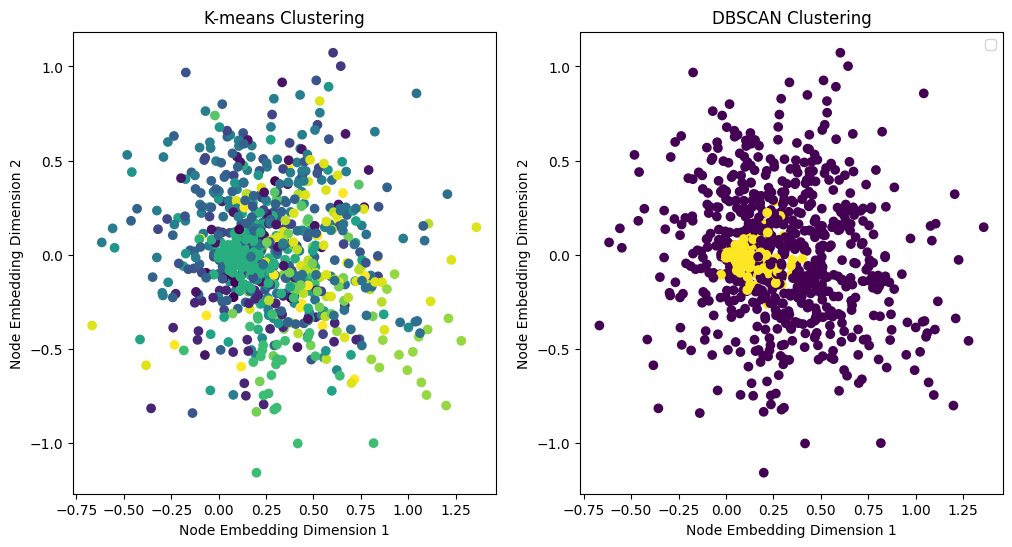

K-means cluster sizes:
[  9  32  39   2  42  63  72  48  93  22  20  42 149  31   6  31  16  27
  37  18]
[133 666]


In [18]:
import pandas as pd
import numpy as np
import networkx as nx
from node2vec import Node2Vec
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv("iron_dealers_data.csv")

# Build the graph
G = nx.DiGraph()
for i, row in df.iterrows():
    buyer_id = str(row["Buyer ID"]) # convert to string
    seller_id = str(row["Seller ID"]) # convert to string
    amount = row["Value"]
    G.add_edge(buyer_id, seller_id, weight=amount)

# Learn node embeddings with Node2Vec
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200)
model = node2vec.fit(window=10, min_count=1)

# Prepare the data for clustering
X = np.array([model.wv.get_vector(str(node)) for node in G.nodes()])

# Use K-means clustering
kmeans = KMeans(n_clusters=20, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Use DBSCAN clustering
dbscan = DBSCAN(eps=1, min_samples=20)
dbscan_labels = dbscan.fit_predict(X)

# Plot the results
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=kmeans_labels)
plt.title("K-means Clustering")
plt.xlabel("Node Embedding Dimension 1")
plt.ylabel("Node Embedding Dimension 2")
plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], c=dbscan_labels)
plt.title("DBSCAN Clustering")
plt.xlabel("Node Embedding Dimension 1")
plt.ylabel("Node Embedding Dimension 2")
plt.legend()
plt.show()

# Print the cluster sizes
print("K-means cluster sizes:")
print(np.bincount(kmeans_labels))
# change -1 to 1 to avoid error
dbscan_labels[dbscan_labels == -1] = 1
print(np.bincount(dbscan_labels))
